In [31]:
import os
import re

from glob import glob

import kneed
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.svm import SVC

from matplotlib import pyplot as plt
import scanpy as sc

Read different expressed genes

In [2]:
def read_different_expressed_genes(input_dir, topn=-1):
    u"""
    read different expressed genes between different disease
    
    :param input_dir: path to input_dir
    :param topn: only select topn genes by avg_logFC
    """
    
    files = glob(os.path.join(input_dir, "*/disease/markers.xlsx"))
    
    data = []
    for i in files:
        temp = pd.read_excel(i, index_col=0)
        
        temp = temp.loc[temp["p_val_adj"] < 0.05, ]
        temp = temp.loc[temp["avg_logFC"].abs() > 0.5, ]
        temp = temp.sort_values(by = "avg_logFC")
        temp["ident"] = i.split("/")[-3]
        
        if topn > 0:
            data.append(temp.iloc[:topn, :])
            data.append(temp.iloc[-topn:, :])
        else:
            data.append(temp)
        
    
    return pd.concat(data)
    
markers = read_different_expressed_genes("../../../03_each_cells/each")

Prepare meta info and expression value

In [3]:
data = sc.read_h5ad("/mnt/raid62/Lung_cancer_10x/00_data_ingest/00_raw_data/raw_counts_clean.csv.h5ad")

Format data

In [8]:
meta = pd.read_csv("../../../02_rds/meta.csv", index_col=0)

/home/zhangyiming/.local/share/virtualenvs/scanpy-UGAxTWFP/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (11,12,13,14,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Remove data from NM

In [14]:
cells = [x for x in data.obs.index if not x.startswith("BT")]

In [15]:
mat = data.to_df().loc[cells, ]

In [17]:
mat = mat.loc[cells, ]

In [18]:
data = sc.AnnData(mat, obs = data.obs.loc[cells, :])

In [64]:
data.obs["Disease"] = ["Other" for i in range(data.obs.shape[0])]

data.obs["Disease"] = meta["Disease"]

data.obs.loc[pd.isna(data.obs["Disease"]), "Disease"] = "Other"

In [24]:
data.write("../../../02_rds/scanpy_classifer.h5ad")

... storing 'Disease' as categorical


In [4]:
data = sc.read_h5ad("../../../02_rds/scanpy_classifer.h5ad")

## 1. get immu cell genes

In [28]:
immu_cells = [
    'B_cells',
    'Granulocyte',
    'CD8',
    'CD4',
    'Neuroendocrine',
    'Mast',
    'Dendritic',
    'Monocytes',
    'Treg',
    'NK'
]

markers = markers.loc[markers["ident"].isin(immu_cells), :]

## 2. Test PCA

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 5, random_state = 0)

res = pca.fit_transform(data.X)

In [66]:
def make_pca_plot(pca, object, pcs=(1, 2)):
    u"""
    make pca scatter plots
    
    """
    pca = pd.DataFrame(pca)
    pca.columns = ["PC" + str(i + 1) for i in range(pca.shape[1]) ]
    pca.index = object.obs.index

    pca["Disease"] = object.obs["Disease"]
        
    sns.scatterplot(data=pca, x="PC" + str(pcs[0]), y="PC" + str(pcs[1]), hue="Disease")

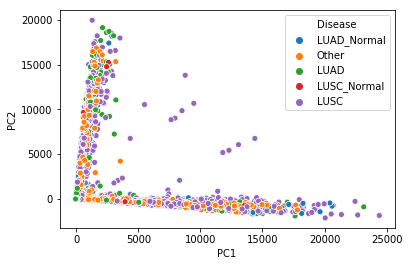

In [67]:
make_pca_plot(res, data)

In [69]:
res = pca.fit_transform(data.to_df().loc[:, markers["gene"].unique()])

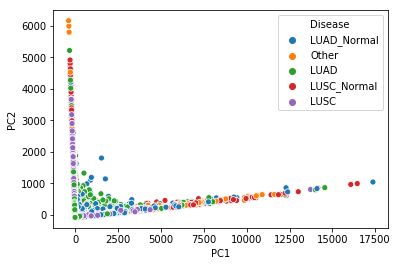

In [70]:
make_pca_plot(res, data)

In [71]:
len(markers["gene"].unique())

457

## 3. try RandomForest

In [5]:
STAGE = {
    "LUAD": 1,
    "LUSC": 2,
    "LUAD_Normal": 3,
    "LUSC_Normal": 4,
    "Other": 5
}


def find_best_features_by_cv(
    data, 
    init_features=None, 
    n_iter=10, 
    random_state=0, 
    n_estimitors=100, 
    max_depth=2, 
    n_jobs=10,
    cv=10,
    methods="RF"
):
    u"""
    Find best features by crossvalidation
    :param data: 
    """
    clf = None
    if methods == "RF":
        clf = RandomForestClassifier(n_estimators=n_estimitors, max_depth=max_depth, random_state=random_state, n_jobs=n_jobs)
    elif methods == "SVM":
        clf = SVC(
            C=1.0, 
            kernel=i, 
            degree=3, 
            gamma='auto_deprecated', 
            coef0=0.0, 
            shrinking=True, 
            probability=False, 
            tol=0.001, 
            cache_size=200, 
            class_weight=None, 
            verbose=False, 
            max_iter=-1, 
            decision_function_shape='ovr', 
            random_state=random_state
        )
    elif methods == "KNN":
        clf = KNeighborsClassifier(n_neighbors=30)
    elif methods == "ANN":
        clf = MLPClassifier()
    
    if init_features is None:
        init_features = data.to_df().columns
        
    init_features = list(set(init_features) & set(data.to_df().columns))
            
    res = []
    for i in range(n_iter):
        mat = data.to_df().loc[:, init_features]
        cv_results = cross_validate(clf, X=mat, y=data.obs["Disease"], cv=cv, n_jobs=n_jobs, return_estimator=True)
    
        res.append(
            {
                "iter": i,
                "test_score": cv_results["test_score"],
                "features": init_features
            }
        )
        
        importance = [] 
        for idx, estimator in enumerate(cv_results["estimator"]):
            importance.append(
                pd.DataFrame(
                    estimator.feature_importances_,
                    index=init_features,
                )
            )


        importance = pd.concat(importance, axis=1)
        
        importance = importance > 0
        importance = importance.sum(axis=1)
        
        init_features = importance[importance > (cv / 2)].index
        
    return res


def test_classifer(
    train_data,
    test_data,
    features=None,
    n_iter=10, 
    random_state=0, 
    n_estimitors=100, 
    max_depth=2, 
    n_jobs=10,
    cv=10
):
    u"""
    Test classifer train by single cells data set on bulk data set
    """
    
    rf = RandomForestClassifier(n_estimators=n_estimitors, max_depth=max_depth, random_state=random_state, n_jobs=n_jobs)
    
    if features is None:
        features = list(set(train_data.to_df().columns) & set(test_data.to_df().columns))
        
    features = list(set(features) & set(train_data.to_df().columns) & set(test_data.to_df()))
    
    res = []
    for i in range(n_iter):
        mat = train_data.to_df().loc[:, features]
        
        rf.fit(mat, train_data.obs["Disease"])
            
        res.append(
            {
                "iter": i,
                "test_score": rf.score(test_data.to_df().loc[:, features], test_data.obs["Disease"]),
                "features": features
            }
        )
            
        sel_features = []

        for idx, x in enumerate(rf.feature_importances_):
            if x > 0:
                sel_features.append(features[idx])
                
        features = sel_features
        
    return res
    
    

In [123]:
# Test all marker genes to classify all cells
res = find_best_features_by_cv(data, markers["gene"].unique())
for i in res:
    print(i["test_score"])

[0.31927152 0.41859002 0.32187562 0.37661435 0.33969137 0.37381197
 0.40141078 0.53427606 0.38638847 0.29865872]
[0.32857616 0.41822577 0.32432611 0.37290549 0.34111531 0.38219028
 0.41167704 0.53606438 0.40245074 0.30488491]
[0.32884106 0.42087486 0.31783562 0.38380025 0.35022187 0.38209094
 0.41531991 0.5023513  0.40933929 0.30197052]
[0.32513245 0.42210007 0.3211471  0.37111729 0.34144645 0.36957314
 0.41406147 0.52023447 0.41235304 0.30163934]
[0.32917219 0.42021259 0.32051792 0.38787337 0.34893039 0.37901116
 0.41147834 0.5218572  0.41536678 0.30392449]
[0.32261589 0.41796086 0.31482217 0.37313729 0.33899596 0.36523496
 0.39124387 0.51569744 0.39950323 0.29948667]
[0.32261589 0.41796086 0.31482217 0.37313729 0.33899596 0.36523496
 0.39124387 0.51569744 0.39950323 0.29948667]
[0.32261589 0.41796086 0.31482217 0.37313729 0.33899596 0.36523496
 0.39124387 0.51569744 0.39950323 0.29948667]
[0.32261589 0.41796086 0.31482217 0.37313729 0.33899596 0.36523496
 0.39124387 0.51569744 0.3995

In [9]:
data_cancer = sc.AnnData(
    data.to_df().loc[[x in ["LUAD", "LUSC"] for x in data.obs["Disease"]], :]
)

data_cancer.obs["Disease"] = data.obs.loc[data_cancer.obs.index, "Disease"]
data_cancer.obs["Cell"] = meta.loc[data_cancer.obs.index, "cell_name"]

data_cancer

AnnData object with n_obs × n_vars = 127593 × 17277 
    obs: 'Disease', 'Cell'

In [162]:
data_cancer.obs.head()

,Disease,Cell
index,,
AK655_AAACCTGAGTCGTTTG-1,LUAD,Ciliated
AK655_AAACCTGGTGTCAATC-1,LUAD,Alveolar II
AK655_AAACCTGTCAGCAACT-1,LUAD,Monocytes
AK655_AAAGATGGTCGGGTCT-1,LUAD,Monocytes
AK655_AAAGATGTCGCCCTTA-1,LUAD,Granulocyte


In [124]:
# Test all marker genes to classify cancer cells
res = find_best_features_by_cv(data_cancer, markers["gene"].unique())
for i in res:
    print(i["test_score"])

[0.70339315 0.67335423 0.74629673 0.80280586 0.83258876 0.66321812
 0.74598323 0.81127048 0.83713457 0.60788463]
[0.68309694 0.68628527 0.74081041 0.77725527 0.81307312 0.68006897
 0.75711263 0.80868407 0.80492202 0.55231601]
[0.6706371  0.67163009 0.74167254 0.78281997 0.81526765 0.67803119
 0.72928913 0.81236774 0.80288424 0.56179951]
[0.69234386 0.68111285 0.75092092 0.80131672 0.82482953 0.67685555
 0.72819186 0.79802492 0.81558116 0.57488831]
[0.6868584  0.67648903 0.72607571 0.80492202 0.81377851 0.67528803
 0.72301905 0.80139509 0.82608355 0.57880712]
[0.68011911 0.6830721  0.72732973 0.7922251  0.81832432 0.67991222
 0.71980563 0.80617603 0.81338663 0.56321028]
[0.68536949 0.68714734 0.72866212 0.79896544 0.81761894 0.67709068
 0.71902187 0.81322988 0.8390156  0.56712909]
[0.66914819 0.6757837  0.73501058 0.79269535 0.81354338 0.68249863
 0.73273768 0.8056274  0.81221099 0.55882122]
[0.70817334 0.67774295 0.72560545 0.81103535 0.81424877 0.67999059
 0.71408418 0.8151109  0.8198

In [125]:
# Test all marker genes (logFC > 1) to classify canccer cells
res = find_best_features_by_cv(data_cancer, markers.loc[markers["avg_logFC"] > 1, "gene"].unique())
for i in res:
    print(i["test_score"])

[0.68333203 0.66152038 0.72725135 0.80037621 0.83243201 0.61509523
 0.72090289 0.78901168 0.83321577 0.65451838]
[0.68458585 0.6476489  0.71157614 0.77364997 0.81910808 0.62450035
 0.72827024 0.78650364 0.84073987 0.6449565 ]
[0.68678003 0.6637931  0.73015127 0.79590877 0.82647543 0.64840505
 0.72717298 0.78368211 0.83588055 0.63954855]
[0.68678003 0.6637931  0.73015127 0.79590877 0.82647543 0.64840505
 0.72717298 0.78368211 0.83588055 0.63954855]
[0.68678003 0.6637931  0.73015127 0.79590877 0.82647543 0.64840505
 0.72717298 0.78368211 0.83588055 0.63954855]
[0.68678003 0.6637931  0.73015127 0.79590877 0.82647543 0.64840505
 0.72717298 0.78368211 0.83588055 0.63954855]
[0.68678003 0.6637931  0.73015127 0.79590877 0.82647543 0.64840505
 0.72717298 0.78368211 0.83588055 0.63954855]
[0.68678003 0.6637931  0.73015127 0.79590877 0.82647543 0.64840505
 0.72717298 0.78368211 0.83588055 0.63954855]
[0.68678003 0.6637931  0.73015127 0.79590877 0.82647543 0.64840505
 0.72717298 0.78368211 0.8358

In [126]:
# Test all marker genes (logFC > 1.5) to classify cancer cells
res = find_best_features_by_cv(data_cancer, markers.loc[markers["avg_logFC"] > 1.5, "gene"].unique())
for i in res:
    print(i["test_score"])

[0.69187368 0.6242163  0.72160828 0.75146955 0.81965671 0.57645584
 0.77372835 0.83368603 0.81174073 0.64958069]
[0.71765536 0.65689655 0.74112391 0.7683204  0.80194373 0.59079865
 0.77459049 0.83831021 0.81127048 0.6466024 ]
[0.71765536 0.65689655 0.74112391 0.7683204  0.80194373 0.59079865
 0.77459049 0.83831021 0.81127048 0.6466024 ]
[0.71765536 0.65689655 0.74112391 0.7683204  0.80194373 0.59079865
 0.77459049 0.83831021 0.81127048 0.6466024 ]
[0.71765536 0.65689655 0.74112391 0.7683204  0.80194373 0.59079865
 0.77459049 0.83831021 0.81127048 0.6466024 ]
[0.71765536 0.65689655 0.74112391 0.7683204  0.80194373 0.59079865
 0.77459049 0.83831021 0.81127048 0.6466024 ]
[0.71765536 0.65689655 0.74112391 0.7683204  0.80194373 0.59079865
 0.77459049 0.83831021 0.81127048 0.6466024 ]
[0.71765536 0.65689655 0.74112391 0.7683204  0.80194373 0.59079865
 0.77459049 0.83831021 0.81127048 0.6466024 ]
[0.71765536 0.65689655 0.74112391 0.7683204  0.80194373 0.59079865
 0.77459049 0.83831021 0.8112

## 3. Using sklearn SelectFromModel to find best features

In [10]:
sel = SelectFromModel(RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0))

sel.fit(data.to_df(), data.obs["Disease"])

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini', max_depth=2,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=0, verbose=0,
                                                 warm_sta

In [11]:
features_all = data.to_df().loc[:, sel.get_support()].columns

In [127]:
res = find_best_features_by_cv(data, features_all)
for i in res:
    print(i["test_score"])

[0.4068543  0.43087519 0.3863832  0.43188291 0.39866879 0.46868894
 0.46913498 0.5406014  0.40851134 0.25398245]
[0.47930464 0.42137157 0.46320948 0.46175243 0.44562554 0.49028049
 0.43528944 0.52665916 0.42142739 0.26901805]
[0.46397351 0.42084175 0.43867144 0.45519571 0.42575667 0.49077723
 0.44605246 0.5308319  0.41596291 0.25401557]
[0.45930464 0.42395444 0.45754686 0.46109014 0.4392675  0.4857105
 0.43075242 0.47748046 0.41751946 0.25938069]
[0.4831457  0.42113977 0.45933506 0.4605603  0.44334062 0.48935325
 0.43280567 0.48407074 0.42348071 0.25928134]
[0.47807947 0.42160336 0.46860719 0.46201735 0.44334062 0.48650528
 0.43353424 0.49625778 0.41831429 0.25699619]
[0.48069536 0.41935163 0.45900391 0.45536128 0.44208226 0.48802861
 0.42803683 0.50476884 0.42722305 0.26557377]
[0.48069536 0.41935163 0.45900391 0.45536128 0.44208226 0.48802861
 0.42803683 0.50476884 0.42722305 0.26557377]
[0.48069536 0.41935163 0.45900391 0.45536128 0.44208226 0.48802861
 0.42803683 0.50476884 0.42722

In [128]:
res = find_best_features_by_cv(data_cancer, features_all)
for i in res:
    print(i["test_score"])

[0.80424732 0.66136364 0.84121013 0.91927267 0.84559918 0.70601144
 0.79583039 0.87169841 0.82467278 0.66008308]
[0.88237599 0.64717868 0.8432479  0.90540011 0.82968885 0.71980563
 0.82678893 0.94678266 0.78587664 0.69754683]
[0.84546666 0.64741379 0.83619406 0.91159182 0.82937534 0.71635708
 0.79716279 0.96700368 0.77905792 0.71541657]
[0.83794373 0.65415361 0.82357552 0.89474097 0.82224312 0.74692374
 0.83470491 0.96880633 0.78814954 0.70953837]
[0.85259776 0.64858934 0.84019124 0.89254644 0.81244612 0.75405596
 0.83196175 0.97531154 0.7850145  0.66251274]
[0.88511872 0.64874608 0.8445803  0.90007054 0.82545654 0.75099929
 0.83337252 0.97515479 0.78979544 0.67881495]
[0.8747747  0.65446708 0.84269927 0.91174857 0.81965671 0.75813152
 0.8259268  0.97562505 0.7814092  0.68861196]
[0.86121777 0.64929467 0.84646132 0.91613763 0.82647543 0.72889725
 0.81534603 0.97194137 0.79465475 0.69315777]
[0.87367761 0.65148903 0.83533192 0.90273532 0.81957834 0.75444784
 0.82130261 0.97280351 0.7882

#### Test on Bulk data
##### SYSU

In [12]:
adc = pd.read_csv("../../../SYSU/ADC.csv", index_col=0)
scc = pd.read_csv("../../../SYSU/SCC.csv", index_col=0)

In [13]:
mat = pd.concat([adc.transpose(), scc.transpose()])

In [14]:
data_sysu = sc.AnnData(mat)

data_sysu.obs["Disease"] = ["LUSC" if x in scc.columns else "LUAD" for x in data_sysu.obs.index]

In [142]:
# Try with selected features
res = test_classifer(train_data=data_cancer, test_data=data_sysu, features=features_all)

for i in res:
    print(i["test_score"], len(i["features"]))
    
    
print("Train by bulk and test on bulk")
# Using features from cancer cells, to split cancer cells
res = find_best_features_by_cv(data_sysu, features_all)
for i in res:
    print(i["test_score"], "Mean score: ", sum(i["test_score"]) / len(i["test_score"]))

0.7142857142857143 192
0.7061224489795919 80
0.6959183673469388 61
0.6918367346938775 49
0.7204081632653061 45
0.7306122448979592 44
0.7244897959183674 43
0.726530612244898 40
0.726530612244898 39
0.7285714285714285 33
Train by bulk and test on bulk
[0.74       0.76       0.79591837 0.71428571 0.69387755 0.75510204
 0.7755102  0.75510204 0.8125     0.77083333] Mean score:  0.757312925170068
[0.72       0.76       0.81632653 0.67346939 0.69387755 0.75510204
 0.7755102  0.75510204 0.8125     0.77083333] Mean score:  0.7532721088435373
[0.74       0.76       0.83673469 0.67346939 0.69387755 0.75510204
 0.7755102  0.73469388 0.8125     0.79166667] Mean score:  0.7573554421768708
[0.74       0.76       0.83673469 0.67346939 0.69387755 0.75510204
 0.73469388 0.73469388 0.8125     0.77083333] Mean score:  0.7511904761904761
[0.72       0.76       0.81632653 0.67346939 0.69387755 0.75510204
 0.7755102  0.73469388 0.8125     0.79166667] Mean score:  0.7533146258503401
[0.72       0.76       0.8

In [143]:
# Try using markers
res = test_classifer(train_data=data_cancer, features=markers.loc[markers["avg_logFC"] > 1, "gene"].unique(), test_data=data_sysu)

for i in res:
    print(i["test_score"], len(i["features"]))
    
    
print("Train by bulk and test on bulk")
# Using features from cancer cells, to split cancer cells
res = find_best_features_by_cv(data_sysu, markers.loc[markers["avg_logFC"] > 1, "gene"].unique())
for i in res:
    print(i["test_score"], "Mean score: ", sum(i["test_score"]) / len(i["test_score"]))

0.5346938775510204 46
0.5346938775510204 36
0.5346938775510204 30
0.5346938775510204 28
0.5346938775510204 28
0.5346938775510204 28
0.5346938775510204 28
0.5346938775510204 28
0.5346938775510204 28
0.5346938775510204 28
Train by bulk and test on bulk
[0.7        0.74       0.75510204 0.65306122 0.69387755 0.7755102
 0.65306122 0.67346939 0.8125     0.75      ] Mean score:  0.7206581632653061
[0.7        0.74       0.7755102  0.69387755 0.69387755 0.75510204
 0.63265306 0.71428571 0.79166667 0.70833333] Mean score:  0.7205306122448979
[0.7        0.74       0.7755102  0.69387755 0.71428571 0.73469388
 0.65306122 0.69387755 0.79166667 0.72916667] Mean score:  0.7226139455782314
[0.68       0.74       0.75510204 0.67346939 0.71428571 0.73469388
 0.65306122 0.69387755 0.79166667 0.75      ] Mean score:  0.7186156462585035
[0.7        0.74       0.75510204 0.67346939 0.73469388 0.75510204
 0.65306122 0.69387755 0.83333333 0.72916667] Mean score:  0.726780612244898
[0.7        0.74       0.7

In [144]:
# Try using markers
res = test_classifer(train_data=data_cancer, features=markers.loc[markers["avg_logFC"] > 0.5, "gene"].unique(), test_data=data_sysu)

for i in res:
    print(i["test_score"], len(i["features"]))
    
print("Train by bulk and test on bulk")
# Using features from cancer cells, to split cancer cells
res = find_best_features_by_cv(data_sysu, markers.loc[markers["avg_logFC"] > 0.5, "gene"].unique())
for i in res:
    print(i["test_score"], "Mean score: ", sum(i["test_score"]) / len(i["test_score"]))

0.5346938775510204 281
0.5346938775510204 88
0.5346938775510204 56
0.5346938775510204 46
0.5346938775510204 41
0.5346938775510204 38
0.5346938775510204 34
0.5346938775510204 33
0.5346938775510204 31
0.5346938775510204 30
Train by bulk and test on bulk
[0.7        0.74       0.7755102  0.67346939 0.73469388 0.83673469
 0.65306122 0.73469388 0.83333333 0.79166667] Mean score:  0.7473163265306122
[0.76       0.72       0.75510204 0.69387755 0.69387755 0.81632653
 0.63265306 0.71428571 0.85416667 0.72916667] Mean score:  0.7369455782312926
[0.7        0.72       0.79591837 0.63265306 0.67346939 0.83673469
 0.65306122 0.73469388 0.8125     0.77083333] Mean score:  0.7329863945578231
[0.7        0.72       0.83673469 0.71428571 0.73469388 0.85714286
 0.65306122 0.75510204 0.85416667 0.75      ] Mean score:  0.7575187074829931
[0.7        0.72       0.81632653 0.67346939 0.71428571 0.83673469
 0.67346939 0.73469388 0.83333333 0.75      ] Mean score:  0.7452312925170068
[0.68       0.74       

Select features from single cells (Only cancer cells)

In [15]:
sel.fit(data_cancer.to_df(), data_cancer.obs["Disease"])
features_cancer = data_cancer.to_df().loc[:, sel.get_support()].columns

In [139]:
# Using features from cancer cells, to split all cells
res = test_classifer(train_data=data, test_data=data_sysu, features=features_cancer)
for i in res:
    print(i["test_score"])

0.6816326530612244
0.5877551020408164
0.673469387755102
0.5755102040816327
0.6326530612244898
0.6081632653061224
0.6081632653061224
0.6632653061224489
0.6693877551020408
0.6163265306122448


In [145]:
# Using features from cancer cells, to split cancer cells
res = test_classifer(train_data=data_cancer, features=features_cancer, test_data=data_sysu)
for i in res:
    print(i["test_score"], len(i["features"]))
    
print("Train by bulk and test on bulk")
# Using features from cancer cells, to split cancer cells
res = find_best_features_by_cv(data_sysu, features_cancer)
for i in res:
    print(i["test_score"], "Mean score: ", sum(i["test_score"]) / len(i["test_score"]))

0.6632653061224489 187
0.6571428571428571 95
0.6959183673469388 64
0.7204081632653061 54
0.7244897959183674 46
0.7244897959183674 46
0.7244897959183674 46
0.7244897959183674 46
0.7244897959183674 46
0.7244897959183674 46
Train by bulk and test on bulk
[0.74       0.76       0.79591837 0.67346939 0.69387755 0.75510204
 0.75510204 0.75510204 0.85416667 0.77083333] Mean score:  0.7553571428571428
[0.74       0.76       0.79591837 0.67346939 0.67346939 0.7755102
 0.75510204 0.7755102  0.83333333 0.8125    ] Mean score:  0.7594812925170069
[0.74       0.76       0.79591837 0.69387755 0.69387755 0.79591837
 0.75510204 0.73469388 0.85416667 0.77083333] Mean score:  0.7594387755102041
[0.74       0.76       0.81632653 0.69387755 0.67346939 0.75510204
 0.7755102  0.7755102  0.83333333 0.75      ] Mean score:  0.7573129251700679
[0.74       0.76       0.79591837 0.71428571 0.67346939 0.75510204
 0.7755102  0.75510204 0.85416667 0.77083333] Mean score:  0.7594387755102041
[0.74       0.76       0

In [146]:
# Try with selected features
res = find_best_features_by_cv(data_sysu, features_cancer)

for i in res:
    print(i["test_score"], "Mean score: ", sum(i["test_score"]) / len(i["test_score"]))

[0.74       0.76       0.79591837 0.67346939 0.69387755 0.75510204
 0.75510204 0.75510204 0.85416667 0.77083333] Mean score:  0.7553571428571428
[0.74       0.76       0.79591837 0.67346939 0.67346939 0.7755102
 0.75510204 0.7755102  0.83333333 0.8125    ] Mean score:  0.7594812925170069
[0.74       0.76       0.79591837 0.69387755 0.69387755 0.79591837
 0.75510204 0.73469388 0.85416667 0.77083333] Mean score:  0.7594387755102041
[0.74       0.76       0.81632653 0.69387755 0.67346939 0.75510204
 0.7755102  0.7755102  0.83333333 0.75      ] Mean score:  0.7573129251700679
[0.74       0.76       0.79591837 0.71428571 0.67346939 0.75510204
 0.7755102  0.75510204 0.85416667 0.77083333] Mean score:  0.7594387755102041
[0.74       0.76       0.83673469 0.69387755 0.69387755 0.75510204
 0.75510204 0.7755102  0.83333333 0.79166667] Mean score:  0.7635204081632653
[0.74       0.76       0.83673469 0.69387755 0.69387755 0.79591837
 0.7755102  0.73469388 0.85416667 0.79166667] Mean score:  0.767

##### TCGA

In [16]:
adc = pd.read_csv("../../../TCGA/LUAD_raw_expresion.csv", index_col=0)
scc = pd.read_csv("../../../TCGA/LUSC_raw_expresion.csv", index_col=0)

In [17]:
adc.index = [x.split("|")[0] for x in adc.index]
scc.index = [x.split("|")[0] for x in scc.index]

mat = pd.concat([adc.transpose(), scc.transpose()])
cols = {i: idx for idx, i in enumerate(mat.columns)}
mat = mat.iloc[:, list(cols.values())]

data_tcga = sc.AnnData(mat)

data_tcga.obs["Disease"] = ["LUSC" if x in scc.columns else "LUAD" for x in data_tcga.obs.index]

In [149]:
# Using features from cancer cells, to split cancer cells
res = test_classifer(train_data=data_cancer, features=features_all, test_data=data_tcga)
for i in res:
    print(i["test_score"], len(i["features"]))

# Try with selected features
res = find_best_features_by_cv(data_tcga, features_all)

for i in res:
    print(i["test_score"], "Mean score: ", sum(i["test_score"]) / len(i["test_score"]))

0.5128432240921169 182
0.5172719220549159 84
0.5783879539415412 58
0.5110717449069974 48
0.5181576616474757 39
0.5199291408325952 37
0.5287865367581931 34
0.5137289636846767 32
0.5137289636846767 32
0.5137289636846767 32
[0.90350877 0.86842105 0.87719298 0.92035398 0.92035398 0.92035398
 0.91964286 0.92857143 0.94642857 0.91964286] Mean score:  0.9124470468205914
[0.89473684 0.85964912 0.88596491 0.92920354 0.92035398 0.91150442
 0.90178571 0.9375     0.95535714 0.91964286] Mean score:  0.9115698538381352
[0.9122807  0.86842105 0.87719298 0.92920354 0.92035398 0.92035398
 0.91071429 0.92857143 0.95535714 0.91964286] Mean score:  0.9142091955552598
[0.9122807  0.87719298 0.87719298 0.92035398 0.92920354 0.92920354
 0.90178571 0.92857143 0.95535714 0.91964286] Mean score:  0.9150784871470712
[0.90350877 0.85964912 0.88596491 0.92035398 0.92035398 0.92035398
 0.91071429 0.92857143 0.95535714 0.91964286] Mean score:  0.9124470468205914
[0.9122807  0.87719298 0.87719298 0.92920354 0.9203539

In [150]:
# Using features from cancer cells, to split cancer cells
res = test_classifer(train_data=data_cancer, features=markers.loc[markers["avg_logFC"] > 1, "gene"].unique(), test_data=data_tcga)
for i in res:
    print(i["test_score"], len(i["features"]))


# Try using markers
res = find_best_features_by_cv(data_tcga, markers.loc[markers["avg_logFC"] > 1, "gene"].unique())

for i in res:
    print(i["test_score"], "Mean score: ", sum(i["test_score"]) / len(i["test_score"]))  

0.5101860053144376 48
0.5101860053144376 39
0.5101860053144376 32
0.5101860053144376 28
0.5101860053144376 25
0.5101860053144376 25
0.5101860053144376 25
0.5101860053144376 25
0.5101860053144376 25
0.5101860053144376 25
[0.87719298 0.85964912 0.85087719 0.91150442 0.92035398 0.85840708
 0.90178571 0.875      0.88392857 0.94642857] Mean score:  0.8885127642114135
[0.86842105 0.85964912 0.85087719 0.90265487 0.90265487 0.84070796
 0.89285714 0.875      0.86607143 0.94642857] Mean score:  0.880532221039324
[0.87719298 0.85964912 0.85087719 0.90265487 0.91150442 0.86725664
 0.875      0.86607143 0.86607143 0.92857143] Mean score:  0.880484951316344
[0.86842105 0.86842105 0.85964912 0.89380531 0.92035398 0.85840708
 0.88392857 0.875      0.875      0.92857143] Mean score:  0.883155759975159
[0.87719298 0.87719298 0.85964912 0.89380531 0.91150442 0.84955752
 0.90178571 0.875      0.875      0.94642857] Mean score:  0.8867116630070753
[0.87719298 0.87719298 0.85964912 0.89380531 0.91150442 0.

In [152]:
# Using features from cancer cells, to split cancer cells
res = test_classifer(train_data=data_cancer, features=markers.loc[markers["avg_logFC"] > 0.5, "gene"].unique(), test_data=data_tcga)
for i in res:
    print(i["test_score"], len(i["features"]))

# Try using markers
res = find_best_features_by_cv(data_tcga, markers.loc[markers["avg_logFC"] > 0.5, "gene"].unique())

for i in res:
    print(i["test_score"], "Mean score: ", sum(i["test_score"]) / len(i["test_score"]))

0.5101860053144376 274
0.5101860053144376 90
0.5101860053144376 57
0.5101860053144376 44
0.5101860053144376 38
0.5101860053144376 35
0.5101860053144376 33
0.5101860053144376 33
0.5101860053144376 33
0.5101860053144376 33
[0.89473684 0.86842105 0.87719298 0.91150442 0.91150442 0.84955752
 0.86607143 0.88392857 0.86607143 0.9375    ] Mean score:  0.8866488677445827
[0.89473684 0.87719298 0.87719298 0.90265487 0.9380531  0.86725664
 0.88392857 0.89285714 0.875      0.91964286] Mean score:  0.8928515980216026
[0.92105263 0.86842105 0.88596491 0.90265487 0.9380531  0.86725664
 0.89285714 0.89285714 0.85714286 0.92857143] Mean score:  0.8954831769689712
[0.87719298 0.87719298 0.88596491 0.91150442 0.94690265 0.85840708
 0.89285714 0.89285714 0.875      0.9375    ] Mean score:  0.8955379322199304
[0.86842105 0.88596491 0.87719298 0.89380531 0.9380531  0.87610619
 0.88392857 0.89285714 0.86607143 0.9375    ] Mean score:  0.8919900691995476
[0.90350877 0.85964912 0.87719298 0.89380531 0.9557522

In [154]:
# Using features selected from cancer cells to split tcga data
res = test_classifer(train_data=data_cancer, features=features_cancer, test_data=data_tcga)
for i in res:
    print(i["test_score"], len(i["features"]))

# Using features from cancer cells, to split all cells
res = find_best_features_by_cv(data_tcga, features_cancer)
for i in res:
    print(i["test_score"], "Mean score: ", sum(i["test_score"]) / len(i["test_score"]))

0.5101860053144376 181
0.5367581930912312 80
0.5155004428697962 57
0.5119574844995571 49
0.5633303808680248 37
0.5305580159433126 34
0.5349867139061116 33
0.5199291408325952 32
0.5199291408325952 32
0.5199291408325952 32
[0.9122807  0.86842105 0.87719298 0.92920354 0.92035398 0.91150442
 0.91964286 0.91071429 0.94642857 0.91964286] Mean score:  0.9115385255173332
[0.9122807  0.88596491 0.88596491 0.92920354 0.92035398 0.92035398
 0.91964286 0.91964286 0.95535714 0.92857143] Mean score:  0.9177336316454852
[0.9122807  0.86842105 0.88596491 0.92035398 0.92035398 0.92920354
 0.91071429 0.9375     0.95535714 0.91964286] Mean score:  0.9159792456805731
[0.9122807  0.86842105 0.88596491 0.92035398 0.92035398 0.92920354
 0.91071429 0.9375     0.95535714 0.91964286] Mean score:  0.9159792456805731
[0.9122807  0.86842105 0.88596491 0.92035398 0.92035398 0.92920354
 0.91071429 0.9375     0.95535714 0.91964286] Mean score:  0.9159792456805731
[0.9122807  0.86842105 0.88596491 0.92035398 0.9203539

### Try to identify LUAD, LUSC and normal

In [111]:
data_lu = sc.AnnData(
    data.to_df().loc[[x.startswith("LU") for x in data.obs["Disease"]], :]
)

data_lu.obs["Disease"] = [x if x in ["LUAD", "LUSC"] else "Normal" for x in data.obs.loc[data_lu.obs.index, "Disease"]]

In [112]:
# Try using markers
res = find_best_features_by_cv(data_lu, markers.loc[markers["avg_logFC"] > 0.5, "gene"].unique())

for i in res:
    print(i["test_score"])

[0.55688939 0.55507739 0.55557233 0.55901231 0.55769521 0.55867694
 0.55671349 0.55535418 0.5607159  0.55331521]
[0.57463194 0.56610042 0.57029598 0.57486974 0.57128833 0.57287419
 0.56826763 0.56539798 0.57446005 0.5663797 ]
[0.57093243 0.56262741 0.56855935 0.56777165 0.5659266  0.56660625
 0.56434073 0.56252832 0.5663797  0.56215073]
[0.5597584  0.55500189 0.55632739 0.55931435 0.55739314 0.55610935
 0.55316417 0.55603383 0.55754418 0.55754418]
[0.56534541 0.5587014  0.55934763 0.55878577 0.55988521 0.55845039
 0.554599   0.55006797 0.55686452 0.55595831]
[0.56625142 0.55749339 0.56931441 0.56618591 0.56449177 0.56343453
 0.56690832 0.56320797 0.56713487 0.56434073]
[0.55500189 0.55122688 0.56017819 0.55984294 0.55346624 0.55769521
 0.54863314 0.552409   0.55671349 0.5506721 ]
[0.57304643 0.56927142 0.56893688 0.56641244 0.56819212 0.56502039
 0.56554901 0.56396315 0.56675729 0.55973418]
[0.57606644 0.57055493 0.57497735 0.57154723 0.56668177 0.56894729
 0.56849419 0.56524694 0.5720

In [113]:
# Try using markers
res = find_best_features_by_cv(data_lu, markers.loc[markers["avg_logFC"] > 1, "gene"].unique())

for i in res:
    print(i["test_score"])

[0.55779539 0.54798037 0.55776201 0.56225931 0.55271107 0.55407038
 0.55535418 0.55452349 0.55701556 0.55172935]
[0.56715742 0.5598339  0.57339172 0.56648796 0.5663797  0.56758798
 0.56403866 0.56335901 0.56841867 0.56237728]
[0.5603624  0.55500189 0.56954092 0.563543   0.56426522 0.56532246
 0.5619997  0.55988521 0.56721039 0.56018728]
[0.5603624  0.55500189 0.56954092 0.563543   0.56426522 0.56532246
 0.5619997  0.55988521 0.56721039 0.56018728]
[0.5603624  0.55500189 0.56954092 0.563543   0.56426522 0.56532246
 0.5619997  0.55988521 0.56721039 0.56018728]
[0.5603624  0.55500189 0.56954092 0.563543   0.56426522 0.56532246
 0.5619997  0.55988521 0.56721039 0.56018728]
[0.5603624  0.55500189 0.56954092 0.563543   0.56426522 0.56532246
 0.5619997  0.55988521 0.56721039 0.56018728]
[0.5603624  0.55500189 0.56954092 0.563543   0.56426522 0.56532246
 0.5619997  0.55988521 0.56721039 0.56018728]
[0.5603624  0.55500189 0.56954092 0.563543   0.56426522 0.56532246
 0.5619997  0.55988521 0.5672

In [114]:
# Try using markers
res = find_best_features_by_cv(data_lu, markers.loc[markers["avg_logFC"] > 1.5, "gene"].unique())

for i in res:
    print(i["test_score"])

[0.51634579 0.50955077 0.51948052 0.51627275 0.51585863 0.51404622
 0.51782208 0.51344208 0.51752001 0.51057242]
[0.51234428 0.50705927 0.51812141 0.51227063 0.51404622 0.51427277
 0.51555656 0.51306449 0.5157076  0.50974173]
[0.51234428 0.50705927 0.51812141 0.51227063 0.51404622 0.51427277
 0.51555656 0.51306449 0.5157076  0.50974173]
[0.51234428 0.50705927 0.51812141 0.51227063 0.51404622 0.51427277
 0.51555656 0.51306449 0.5157076  0.50974173]
[0.51234428 0.50705927 0.51812141 0.51227063 0.51404622 0.51427277
 0.51555656 0.51306449 0.5157076  0.50974173]
[0.51234428 0.50705927 0.51812141 0.51227063 0.51404622 0.51427277
 0.51555656 0.51306449 0.5157076  0.50974173]
[0.51234428 0.50705927 0.51812141 0.51227063 0.51404622 0.51427277
 0.51555656 0.51306449 0.5157076  0.50974173]
[0.51234428 0.50705927 0.51812141 0.51227063 0.51404622 0.51427277
 0.51555656 0.51306449 0.5157076  0.50974173]
[0.51234428 0.50705927 0.51812141 0.51227063 0.51404622 0.51427277
 0.51555656 0.51306449 0.5157

---
## Find out which Cell is most useful when classify different diseases

In [18]:
def find_best_cells(train_data, test_data, features, n_iter=10):
    res = []

    for i in train_data.obs["Cell"].unique():
        print(i)
        temp_cells = train_data.obs.loc[train_data.obs["Cell"] == i, :]
                
        temp_data = sc.AnnData(
            train_data.to_df().loc[temp_cells.index, :]
        )

        temp_data.obs = temp_cells

        temp_res = test_classifer(train_data=temp_data, features=features, test_data=test_data, n_iter=n_iter)

        res.append(
            pd.DataFrame({
                "score": [x["test_score"] for x in temp_res],
                "Cell": [i for x in range(len(temp_res))]
            })
        )

    return pd.concat(res)

Try each cells on sysu

Ciliated
Alveolar II
Monocytes
Granulocyte
Dendritic
NK
CD4
CD8
Epithelial
B cells
Club
Neuroendocrine
Treg
Mast
Basal
Endothelial
Fibroblasts


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

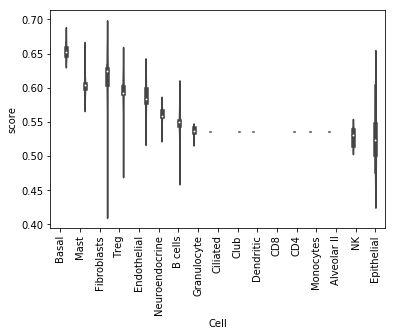

In [189]:
temp = find_best_cells(train_data=data_cancer, test_data=data_sysu, features=markers.loc[markers["avg_logFC"] > 0.5, "gene"].unique())

fig, ax = plt.subplots(figsize=(6, 4))
sns.violinplot(
    x="Cell", 
    y="score", 
    hue = "Cell", 
    data=temp, 
    legend=False, 
    ax=ax, 
    order=temp.groupby('Cell').agg(['mean']).sort_values(by=('score', 'mean'), ascending=False).index
)
ax.get_legend().remove()
plt.xticks(rotation=90)

Ciliated
Alveolar II
Monocytes
Granulocyte
Dendritic
NK
CD4
CD8
Epithelial
B cells
Club
Neuroendocrine
Treg
Mast
Basal
Endothelial
Fibroblasts


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

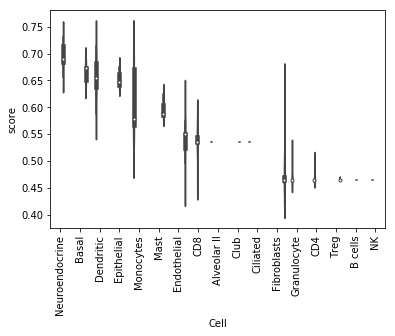

In [190]:
temp = find_best_cells(train_data=data_cancer, test_data=data_sysu, features=features_all)

fig, ax = plt.subplots(figsize=(6, 4))
sns.violinplot(
    x="Cell", 
    y="score", 
    hue = "Cell", 
    data=temp, 
    legend=False, 
    ax=ax, 
    order=temp.groupby('Cell').agg(['mean']).sort_values(by=('score', 'mean'), ascending=False).index
)
ax.get_legend().remove()
plt.xticks(rotation=90)

Ciliated
Alveolar II
Monocytes
Granulocyte
Dendritic
NK
CD4
CD8
Epithelial
B cells
Club
Neuroendocrine
Treg
Mast
Basal
Endothelial
Fibroblasts


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

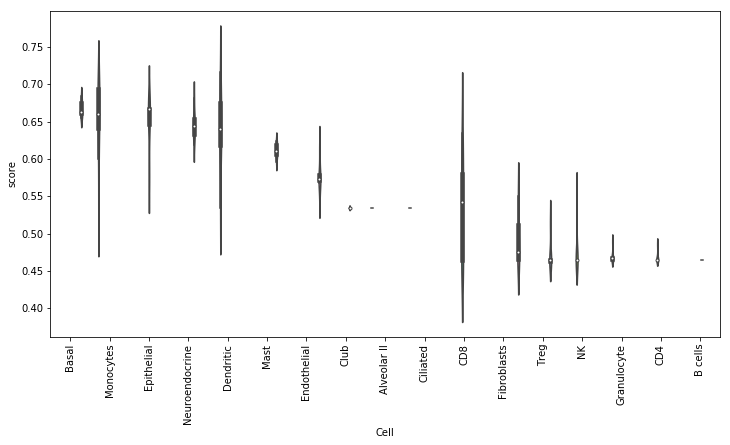

In [188]:
temp = find_best_cells(train_data=data_cancer, test_data=data_sysu, features=features_cancer)

fig, ax = plt.subplots(figsize=(6, 4))
sns.violinplot(
    x="Cell", 
    y="score", 
    hue = "Cell", 
    data=temp, 
    legend=False, 
    ax=ax, 
    order=temp.groupby('Cell').agg(['mean']).sort_values(by=('score', 'mean'), ascending=False).index
)
ax.get_legend().remove()
plt.xticks(rotation=90)

Try each cells on TCGA

Ciliated
Alveolar II
Monocytes
Granulocyte
Dendritic
NK
CD4
CD8
Epithelial
B cells
Club
Neuroendocrine
Treg
Mast
Basal
Endothelial
Fibroblasts


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

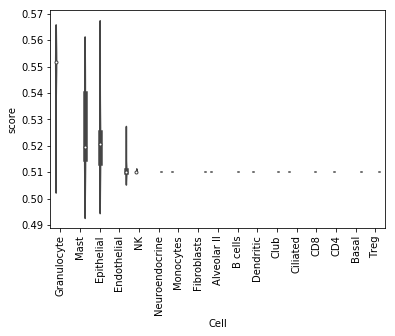

In [191]:
temp = find_best_cells(train_data=data_cancer, test_data=data_tcga, features=markers.loc[markers["avg_logFC"] > 0.5, "gene"].unique())

fig, ax = plt.subplots(figsize=(6, 4))
sns.violinplot(
    x="Cell", 
    y="score", 
    hue = "Cell", 
    data=temp, 
    legend=False, 
    ax=ax, 
    order=temp.groupby('Cell').agg(['mean']).sort_values(by=('score', 'mean'), ascending=False).index
)
ax.get_legend().remove()
plt.xticks(rotation=90)

Ciliated
Alveolar II
Monocytes
Granulocyte
Dendritic
NK
CD4
CD8
Epithelial
B cells
Club
Neuroendocrine
Treg
Mast
Basal
Endothelial
Fibroblasts


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

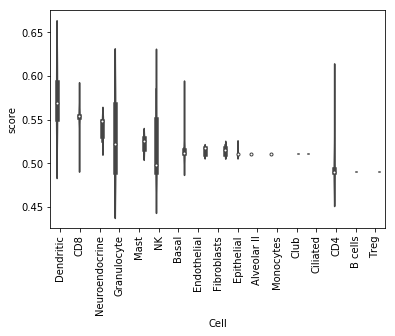

In [192]:
temp = find_best_cells(train_data=data_cancer, test_data=data_tcga, features=features_all)

fig, ax = plt.subplots(figsize=(6, 4))
sns.violinplot(
    x="Cell", 
    y="score", 
    hue = "Cell", 
    data=temp, 
    legend=False, 
    ax=ax, 
    order=temp.groupby('Cell').agg(['mean']).sort_values(by=('score', 'mean'), ascending=False).index
)
ax.get_legend().remove()
plt.xticks(rotation=90)

Ciliated
Alveolar II
Monocytes
Granulocyte
Dendritic
NK
CD4
CD8
Epithelial
B cells
Club
Treg
Mast
Basal
Endothelial
Fibroblasts


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

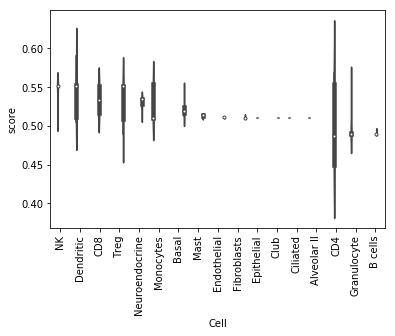

In [193]:
temp = find_best_cells(train_data=data_cancer, test_data=data_tcga, features=features_cancer)

fig, ax = plt.subplots(figsize=(6, 4))
sns.violinplot(
    x="Cell", 
    y="score", 
    hue = "Cell", 
    data=temp, 
    legend=False, 
    ax=ax, 
    order=temp.groupby('Cell').agg(['mean']).sort_values(by=('score', 'mean'), ascending=False).index
)
ax.get_legend().remove()
plt.xticks(rotation=90)

---
#### Test different classifier using data_cancer and features_cancer

In [60]:
def test_diff_classifer(
    train_data,
    test_data,
    features=None,
    n_iter=10, 
    random_state=0, 
    n_estimitors=100, 
    max_depth=2, 
    n_jobs=10,
    cv=10,
    n_neighbors=30,
    methods=None
):
    u"""
    Test classifer train by single cells data set on bulk data set
    """
    
    clf = None
    if methods == "RF":
        clf = RandomForestClassifier(n_estimators=n_estimitors, max_depth=max_depth, random_state=random_state, n_jobs=n_jobs)
    elif methods == "SVM":
        clf = SVC(
            C=1.0, 
            degree=3, 
            gamma='auto', 
            coef0=0.0, 
            shrinking=True, 
            probability=False, 
            tol=0.001, 
            cache_size=200, 
            class_weight=None, 
            verbose=False, 
            max_iter=-1, 
            decision_function_shape='ovr', 
            random_state=random_state
        )
    elif methods == "KNN":
        clf = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=n_jobs)
    elif methods == "ANN":
        clf = MLPClassifier(random_state=random_state)
    
    if features is None:
        features = list(set(train_data.to_df().columns) & set(test_data.to_df().columns))
        
    features = list(set(features) & set(train_data.to_df().columns) & set(test_data.to_df()))
    
    mat = train_data.to_df().loc[:, features]
        
    clf.fit(mat, train_data.obs["Disease"])
            
    return clf.score(test_data.to_df().loc[:, features], test_data.obs["Disease"])

In [19]:
res = {}
for i in ["RF", "KNN", "ANN"]:
    print(i)
    # Try with selected features
    res[i] = test_diff_classifer(train_data = data_cancer, test_data=data_tcga, features=features_cancer, methods = i)
#     for j in res:
#         print(j["test_score"], "Mean score: ", sum(j["test_score"]) / len(j["test_score"]))

RF
KNN
ANN


In [20]:
res1 = {}
for i in ["RF", "KNN", "ANN"]:
    print(i)
    # Try with selected features
    res1[i] = test_diff_classifer(train_data = data_cancer, test_data=data_sysu, features=features_cancer, methods = i)
    
#     for j in res:
#         print(j["test_score"], "Mean score: ", sum(j["test_score"]) / len(j["test_score"]))

RF
KNN
ANN


In [21]:
print(res)
print(res1)

{'RF': 0.5101860053144376, 'KNN': 0.7201062887511072, 'ANN': 0.7980513728963685}
{'RF': 0.6346938775510204, 'KNN': 0.45714285714285713, 'ANN': 0.5142857142857142}


registerDoMC(10)

markers = foreach(i=1:200, .combine=rbind) %dopar% {
    set.seed(i)
    
    temp = FindMarkers(obj, ident.1 = luad[sample(1:length(luad), 10000)], ident.2 = lusc[sample(1:length(lusc), 10000)],)
    
    temp$ident = i
    temp$gene = rownames(temp)
    
    temp
}

---
### Test classifier on Guo2018

guo = pd.read_csv("../../../Guo2018/GSE99254_NSCLC.TCell.S12346.count.txt.gz", index_col=1, sep = "\t")

In [27]:
guo = guo.loc[:, [x for x in guo.columns if x != "geneID"]]

guo.head()

,NTH10-0616A,NTH11-0616A,NTH15-0616A,NTH17-0616A,NTH2-0616A,NTH4-0616A,NTR15-0616A,NTR16-0616A,NTR17-0616A,NTR18-0616A,...,TTY52-20171219,TTY54-20171219,TTY59-20171219,TTY60-20171219,TTY6-20171219,TTY63-20171219,TTY65-20171219,TTY7-20171219,TTY8-20171219,TTY9-20171219
symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NAT2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
ADA,223,519,0,0,0,120,511,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CDH2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
AKT3,57,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [40]:
SampleDisease = {
    "P0616A": "LUAD",
    "P0616P": "LUAD",
    "P0617": "LUAD",
    "P0729": "LUAD",
    "P0913": "LUSC",
    "P1010": "LUAD",
    "P1011": "LUSC",
    "P1118": "LUAD",
    "P1202": "LUAD",
    "P0619": "LUAD",
    "P0706": "LUSC",
    "P0729": "LUAD",
    "P1120": "LUAD",
    "P1208": "LUAD",
    "P1219": "LUAD"
}

data_guo = sc.AnnData(guo.transpose())

data_guo.obs["Disease"] = [SampleDisease[re.sub(r"^[\w-]+\-(2017)?", "P", x)] for x in data_guo.obs.index]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [42]:
data_guo.write("../../../02_rds/guo.h5ad")

... storing 'Disease' as categorical


In [43]:
res_guo = {}
for i in ["RF", "KNN", "ANN"]:
    print(i)
    # Try with selected features
    res_guo[i] = test_diff_classifer(train_data = data_cancer, test_data=data_guo, features=features_cancer, methods = i)
#     for j in res:
#         print(j["test_score"], "Mean score: ", sum(j["test_score"]) / len(j["test_score"]))

res_guo

RF
KNN
ANN


/home/zhangyiming/.local/share/virtualenvs/scanpy-UGAxTWFP/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'RF': 0.5576705005669853,
 'KNN': 0.7209622549813705,
 'ANN': 0.5908796371294346}

In [44]:
res_guo_markers = {}
for i in ["RF", "KNN", "ANN"]:
    print(i)
    # Try with selected features
    res_guo_markers[i] = test_diff_classifer(train_data = data_cancer, test_data=data_guo, features=markers.loc[markers["avg_logFC"].abs() > 0.5, "gene"].unique(), methods = i)
#     for j in res:
#         print(j["test_score"], "Mean score: ", sum(j["test_score"]) / len(j["test_score"]))

res_guo_markers

RF
KNN
ANN


{'RF': 0.4387655920946055,
 'KNN': 0.7702899724607161,
 'ANN': 0.5223554187591123}

In [54]:
markers_all = pd.read_csv(os.path.abspath("../../../03_each_cells/overall_LUSC_LUAD_DEGS.csv"))

In [57]:
markers_all = markers_all.loc[markers_all["p_val_adj"] < 0.05, :]

Test KNN

In [61]:
res_mk = test_diff_classifer(train_data = data_cancer, test_data=data_guo, features=markers.loc[markers["avg_logFC"].abs() > 0.5, "gene"].unique(), methods = "KNN")
res_mk

0.765349100923376

In [62]:
res_mk_all = test_diff_classifer(train_data = data_cancer, test_data=data_guo, features=markers_all.loc[markers_all["avg_logFC"].abs() > 0.5, "gene"].unique(), methods = "KNN")
res_mk_all

0.7606512230682002

In [65]:
res_mk = {}
for i in range(5, 50, 5):
    print(i)
    res_mk[i] = test_diff_classifer(train_data = data_cancer, test_data=data_guo, features=markers.loc[markers["avg_logFC"].abs() > 0.5, "gene"].unique(), methods = "KNN", n_neighbors=i)
res_mk

5
10
15
20
25
30
35
40
45


{5: 0.760732220962255,
 10: 0.7670500566985259,
 15: 0.7664020735460878,
 20: 0.7666450672282521,
 25: 0.7646201198768832,
 30: 0.765349100923376,
 35: 0.7645391219828285,
 40: 0.765997084075814,
 45: 0.764701117770938}

In [66]:
res_mk = {}
for i in range(5, 50, 5):
    print(i)
    res_mk[i] = test_diff_classifer(train_data = data_cancer, test_data=data_guo, features=markers.loc[markers["avg_logFC"].abs() > 1, "gene"].unique(), methods = "KNN", n_neighbors=i)
res_mk

5
10
15
20
25
30
35
40
45


{5: 0.5481937469625789,
 10: 0.5549975700631784,
 15: 0.538959987040337,
 20: 0.5422809006965819,
 25: 0.5374210270532966,
 30: 0.5409849343917058,
 35: 0.5380690102057346,
 40: 0.5410659322857606,
 45: 0.5377450186295156}

In [68]:
res_mk = {}
for i in range(5, 50, 5):
    print(i)
    res_mk[i] = test_diff_classifer(train_data = data_cancer, test_data=data_guo, features=features_cancer, methods = "KNN", n_neighbors=i)
res_mk

5
10
15
20
25
30
35
40
45


{5: 0.718451320265673,
 10: 0.7221772233921918,
 15: 0.7195852907824396,
 20: 0.7221772233921918,
 25: 0.7192612992062206,
 30: 0.7209622549813705,
 35: 0.721448242345699,
 40: 0.7225012149684108,
 45: 0.721448242345699}

In [69]:
res_mk = {}
for i in range(5, 50, 5):
    print(i)
    res_mk[i] = test_diff_classifer(train_data = data_cancer, test_data=data_guo, features=features_all, methods = "KNN", n_neighbors=i)
res_mk

5
10
15
20
25
30
35
40
45


{5: 0.7719909282358659,
 10: 0.7715049408715373,
 15: 0.7684270208974566,
 20: 0.7683460230034019,
 25: 0.7677790377450187,
 30: 0.7679410335331281,
 35: 0.7677790377450187,
 40: 0.7676980398509639,
 45: 0.7682650251093471}

In [81]:
def find_best_cells_knn(train_data, test_data, features, n_iter=10):
    res = []

    for i in train_data.obs["Cell"].unique():
        print(i)
        temp_cells = train_data.obs.loc[train_data.obs["Cell"] == i, :]
                
        temp_data = sc.AnnData(
            train_data.to_df().loc[temp_cells.index, :]
        )

        temp_data.obs = temp_cells
        
        res_mk = {}
        for j in range(5, 55, 5):
            res_mk[j] = test_diff_classifer(train_data = temp_data, test_data=data_guo, features=features_all, methods = "KNN", n_neighbors=j)

        res.append(
            pd.DataFrame({
                "score": list(res_mk.values()),
                "Cell": [i for x in range(len(res_mk))]
            })
        )

    return pd.concat(res)

Ciliated
Alveolar II
Monocytes
Granulocyte
Dendritic
NK
CD4
CD8
Epithelial
B cells
Club
Neuroendocrine
Treg
Mast
Basal
Endothelial
Fibroblasts


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

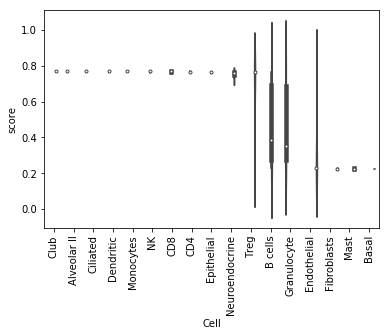

In [82]:
temp = find_best_cells_knn(train_data=data_cancer, test_data=data_guo, features=features_cancer)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

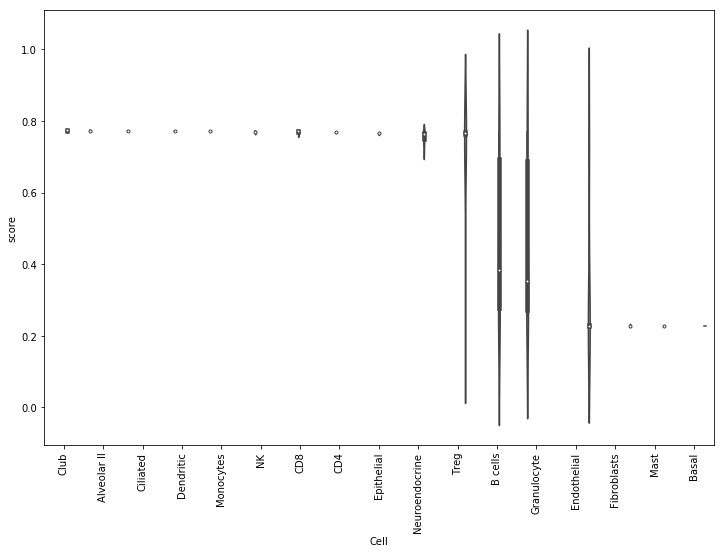

In [83]:

fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(
    x="Cell", 
    y="score", 
    hue = "Cell", 
    data=temp, 
    legend=False, 
    ax=ax, 
    order=temp.groupby('Cell').agg(['mean']).sort_values(by=('score', 'mean'), ascending=False).index
)
ax.get_legend().remove()
plt.xticks(rotation=90)